#### 3. Why is it generally preferable to use Logistic Regression classifier rather than a classical Perceptron (i.e., a single layer of threshold logic units trained using the Perceptron training algorithm)? How can you tweak a Perceptron to make it equivalent to a Logistic Regression classifier?

Perceptron will converge only if the data is linearly separable

#### 4. Why was the logistic activation function a key ingredient in training the first MLPs?
Because previously the step function was used which have only flat surfaces which doesn't have gradients

#### 5. Name three popular activation functions. Can you draw them?
- reLU
- tanh
- sigmoid

#### 6.Suppose you have an MLP composed of one input layer with 10 passthrough neuron, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons. All artificial neurons use the ReLU activation function
- What is the shape of the input matrix X?

    (batch_size, 10)

- What are the shapes of the hidden layer's weight vector $W_h$ and it's bias vector $b_h$?

    (10, 50), (50, 1)

- What are the shapes of the output layer's weight vector $W_o$ and its bias vecto $b_o$?
    (50, 3), (3, 1)

- What is the shape of the network's output matrix Y
    (batch_size, 3)
- Write the equation that computes the networks output matrix Y as a function of $X$, $W_h$, $b_h$, $W_o$, and $b_o$

($X \cdot W_h + b_h) \cdot W_o + b_o$

#### 7. How many neyrons do you need in the output layer if you want to classify email into spam or ham? What activation function should you use in the output layer? If instead you want to tackle MNIST, how many neurons do you need in the output layer and which activation function should you use? What about for getting your network to predict housing prices, as in Chapter 2?
1 activation sigmoid, 10 activation softmax, 1 activation none, or relu

#### 8. What is backpropagation and how does it work? What is the difference between backpropagaion and reverse-mode autodiff?
Backpropagation is an algorithm for optimizing neural network, it's the same thing as autodiff. It works by going forward and backwards through neural network, and computing partial derivatives.

#### 9. Can you list all the hyperparameters you can tweak in a basic MLP? If the MLPP overfits the training data, how could you tweak these hyperparameters to try to solve the problem?
- number of layers
- number of neurons per layer
- activation function
- learning rate

If overfiting then reduce the number of layers reduce the number of neurons per layer

In [2]:
from tensorflow import keras

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_test = X_test / 255.0

In [19]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
flatten = keras.layers.Flatten()(input_)
hidden1 = keras.layers.Dense(30, activation="relu")(flatten)
output = keras.layers.Dense(10, activation="softmax")(hidden1)
model = keras.Model(inputs=[input_], outputs=[output])

model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])

model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 30)                23550     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                310       
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


In [20]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_checkpoint.h5")

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

expon_lr = ExponentialLearningRate(factor=1.005)

model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[
    early_stopping_cb,
    checkpoint_cb,
    expon_lr
])

1719/1719 [==============================] - 3s 2ms/step - loss: 1.3103 - accuracy: 0.6015 - val_loss: 2.3427 - val_accuracy: 0.1004

Text(0, 0.5, 'loss')

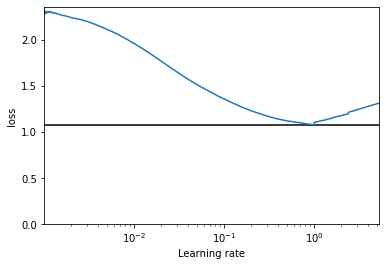

In [21]:
import matplotlib.pyplot as plt

plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("loss")